# Predicting the Volume of Coal Sales in Australia Using Linear Regression with Time Series Data

**Disclaimer: The Department of Resources (QLD) has made a reasonable effort to ensure that the provided data is accurate and complete at the time of publishing. The Department is not responsible for data that is misrepresented, misinterpreted or altered in any way. Derived conclusions and analysis generated from this data are not to be considered attributable to the Department.**
<br>
<br> Source: Department of Resources (QLD)
<br> Data through to 31 December 2022
<br> Current as at April 2023

**Background:** The following project may enable the community and the government to make the best use of our renewable and non-renewable land, mineral and energy resources. Partnerships with our customers and stakeholders are important to us, as we work to deliver policies, programs and services that support industry while reflecting the needs of the broader community.

**Objective:** In this project, the volume of `Hard Coking Coal` sale to `Japan` has been analysed and a machine learning model has been developed to forcast about future sales

# Importing Libraries

In [129]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Loading and exploring data

In [131]:
data = pd.read_csv("Coal-sales-data.csv")
data.head()

,_id,Shipping Date,Country,Port,Coal Type,Volume,Value
0,1,2018-01-08T00:00:00,India,Hay Point,Hard Coking Coal,8937,2343761
1,2,2016-10-13T00:00:00,China,Abbot Point,Thermal Coal,66951,5997801
2,3,2015-09-11T00:00:00,South Korea,Dalrymple Bay,Hard Coking Coal,15619,2056586
3,4,2015-07-23T00:00:00,Taiwan,Gladstone,Thermal Coal,9735,801229
4,5,2015-10-03T00:00:00,Taiwan,Gladstone,Thermal Coal,24554,1943597


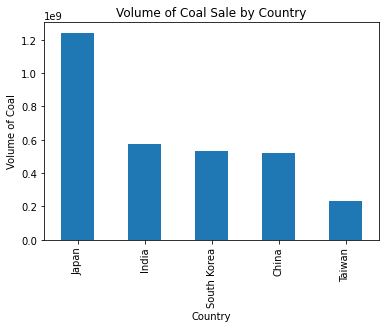

In [142]:
# group data by `country`
data.groupby("Country").sum()["Volume"].sort_values(ascending=False).head().plot(kind='bar');
plt.ylabel("Volume of Coal");
plt.title("Volume of Coal Sale by Country");

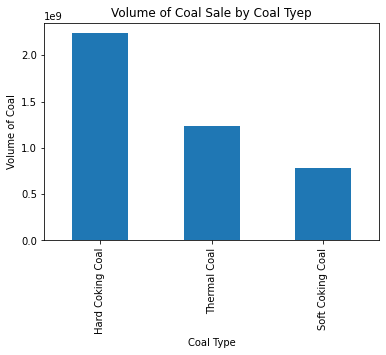

In [143]:
# group data by 'coal type'
data.groupby("Coal Type").sum()["Volume"].sort_values(ascending=False).head().plot(kind='bar');
plt.ylabel("Volume of Coal");
plt.title("Volume of Coal Sale by Coal Tyep");

# Data wrangling

In [171]:
def wrangle(country, coal_type):
    # load data
    df = pd.read_csv("Coal-sales-data.csv")
    # required fields are 'date', 'country', 'coal type', and 'volume'
    df = df[["Shipping Date", "Country", "Coal Type", "Volume"]]
    # select country
    df = df[df["Country"] == country]
    # select coal type
    df = df[df["Coal Type"] == coal_type][["Shipping Date", "Volume"]]
    # date column to datetime
    df["Shipping Date"] = pd.to_datetime(df["Shipping Date"])
    # aggregate in sum by 'date'
    df = df.groupby("Shipping Date").sum()
    # sort by date
    df = df.sort_values(by="Shipping Date")
    # aggregate in sum by months
    df = df.resample('M').sum()
    df = df.dropna()
    return df

In [172]:
# Split data for country: Japan and coal type: Hard Coking Coal
df_japan = wrangle("Japan", "Hard Coking Coal")
df_japan.head()

,Volume
Shipping Date,
1993-03-31,33076
1993-04-30,0
1993-05-31,0
1993-06-30,0
1993-07-31,0


In [173]:
df_japan.isnull().value_counts()

Volume
False     346
dtype: int64

In [174]:
df_japan[df_japan["Volume"] == 0].value_counts()

Volume
0         21
dtype: int64

# Data cleaning and exploring

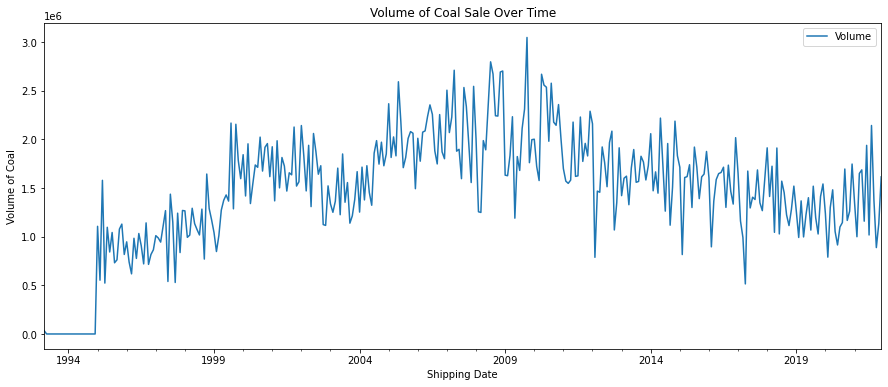

In [175]:
fig, ax = plt.subplots(figsize=(15,6))
df_japan.plot(ax=ax)
plt.ylabel("Volume of Coal");
plt.title("Volume of Coal Sale Over Time");

In [176]:
df_japan = df_japan[df_japan["Volume"] > 0]
df_japan.head()

,Volume
Shipping Date,
1993-03-31,33076
1995-01-31,1106370
1995-02-28,552708
1995-03-31,1579124
1995-04-30,522937


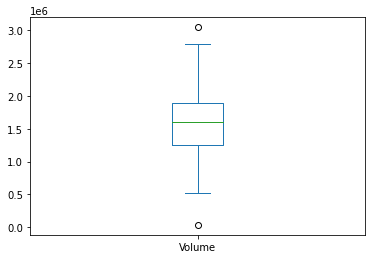

In [177]:
df_japan.Volume.plot(kind='box');

In [178]:
df_japan = df_japan.drop("1993-03-31")

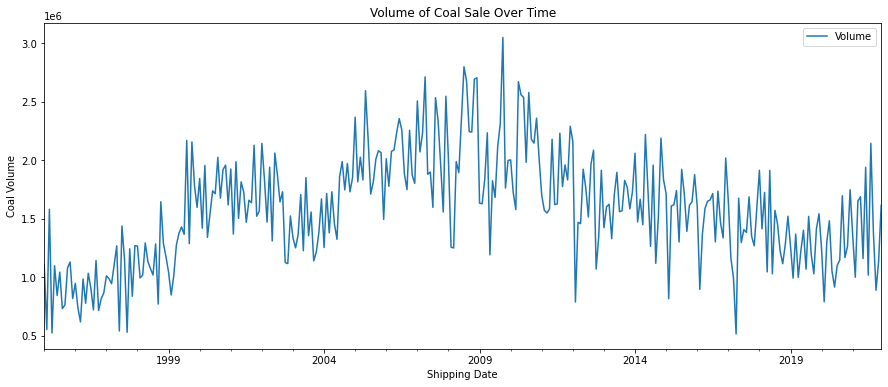

In [180]:
fig, ax = plt.subplots(figsize=(15,6))
df_japan.plot(ax=ax);
plt.ylabel("Coal Volume")
plt.title("Volume of Coal Sale Over Time");

In [87]:
df_japan.Volume.describe()

count    3.240000e+02
mean     1.578684e+06
std      4.708707e+05
min      5.143450e+05
25%      1.255210e+06
50%      1.595860e+06
75%      1.893276e+06
max      3.047322e+06
Name: Volume, dtype: float64

In [101]:
# looking at percentage change
df_japan["Volume_pct"] = df_japan["Volume"].pct_change()*100

In [89]:
df_japan = df_japan.dropna()

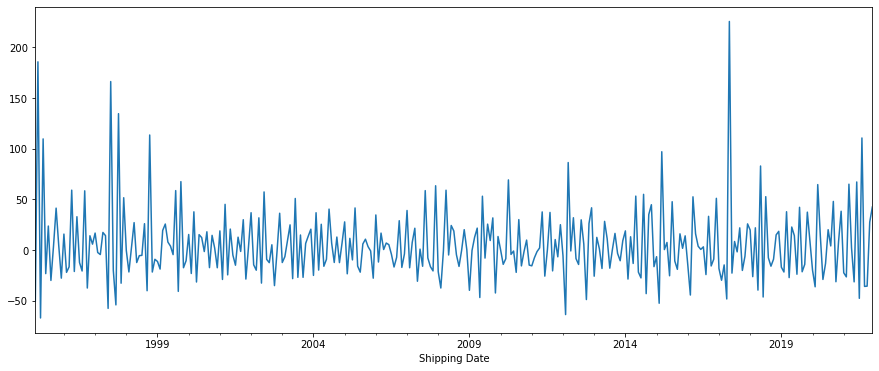

In [90]:
fig, ax = plt.subplots(figsize=(15,6))
df_japan["Volume"].plot(ax=ax);

In [91]:
# looking at rolling average
df_japan["Volume"].rolling(12).mean().head()

Shipping Date
1995-02-28   NaN
1995-03-31   NaN
1995-04-30   NaN
1995-05-31   NaN
1995-06-30   NaN
Name: Volume, dtype: float64

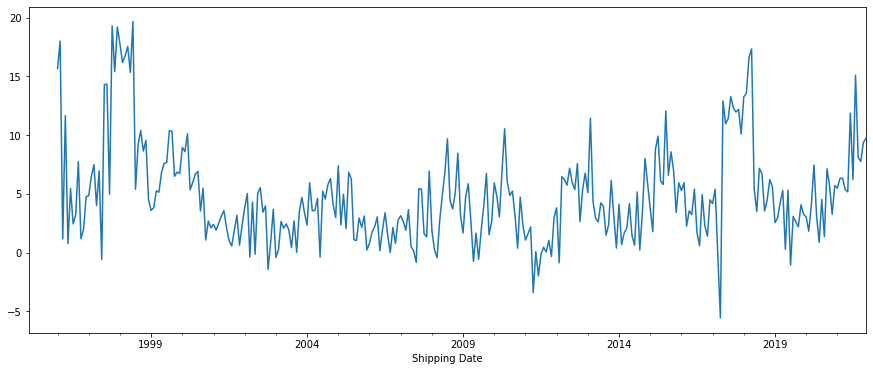

In [93]:
fig, ax = plt.subplots(figsize=(15,6))
df_japan["Volume"].rolling(12).mean().plot(ax=ax); #12 monthly or yearly data

# Preparing data

In [150]:
df_japan = wrangle("Japan", "Hard Coking Coal")
df_japan = df_japan[df_japan["Volume"] > 0]
df_japan = df_japan.drop("1993-03-31")
# creating a column of data from previous date
df_japan["VolumeL1"] = df_japan["Volume"].shift(1)
df_japan = df_japan.dropna()
df_japan.head()

,Volume,VolumeL1
Shipping Date,,
1995-02-28,552708,1106370.0
1995-03-31,1579124,552708.0
1995-04-30,522937,1579124.0
1995-05-31,1096619,522937.0
1995-06-30,842653,1096619.0


In [151]:
df_japan.corr()

,Volume,VolumeL1
Volume,1.000000,0.560845
VolumeL1,0.560845,1.000000


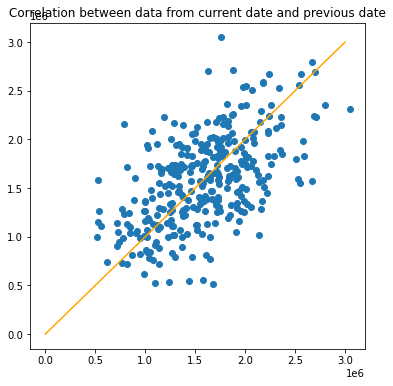

In [154]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=df_japan["Volume"], y=df_japan["VolumeL1"])
ax.plot([0,3000000], [0,3000000], color="orange")
plt.title("Correlation between data from current date and previous date");

In [156]:
# predicting volume of curreent date using volume of previous date
target = "Volume"
y = df_japan[target]
X = df_japan.drop(columns=target)

In [157]:
# spliting test and train data
cutoff = int(len(df_japan)*0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [116]:
len(X_train) + len(X_test) == len(X)

True

In [117]:
from sklearn.metrics import mean_absolute_error

# Building Model

## Calculating Baseline

In [158]:
y_pred_baseline = [y_train.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 1637598.62
Baseline MAE: 384648.23


## Iterate

In [159]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [160]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 306549.58
Test MAE: 334294.3


In [161]:
# generating equation for the model
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]

print(f"Volume = {intercept} + ({coefficient} * VolumeL1)")

Volume = 661486.89 + (0.6 * VolumeL1)


In [162]:
# creating dataframe containing true value and predicted value
df_pred_test = pd.DataFrame(
{
    "y_test": y_test,
    "y_pred": model.predict(X_test)
}
)
df_pred_test.head()

,y_test,y_pred
Shipping Date,,
2016-08-31,1301145,1.684560e+06
2016-09-30,1734985,1.438168e+06
2016-10-31,1464501,1.697136e+06
2016-11-30,1335023,1.535679e+06
2016-12-31,2017451,1.458390e+06


In [127]:
import plotly.express as px

## Communicate the result

In [169]:
fig = px.line(df_pred_test)
fig.update_layout(
    title="Comparison between actual volume and predicted volume of test data",
    xaxis_title = "Shipping Date",
    yaxis_title = "Coal Volume"
                     )
fig.show()